In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Reparameterization Trick

So far, we played around with the log-likelihood, and we ended up with the ELBO. However, there is still a problem with calculating the expected value, because it contains an integral! Therefore, the question is how we can calculate it and why it is better than the MC approximation of the log-likelihood without the variational posterior. In fact, we will use the MC approximation, but now, instead of sampling from the prior $ p(z) $, we will sample from the variational posterior $ q_\phi(z|x) $.

Is it better? Yes, because the variational posterior typically assigns more probability mass to a smaller region than the prior. If you examine the variance of the variational posterior, you will probably notice that the variational posteriors are almost deterministic (whether it is good or bad is an open question). As a result, we should get a better approximation!

However, there is still an issue with the variance of the approximation. If we sample $ z $ from $ q_\phi(z|x) $, plug them into the ELBO, and calculate gradients with respect to the parameters of a neural network $ \phi $, the variance of the gradient may still be pretty large! A possible solution to that, first noticed by statisticians (e.g., see [8]), is the approach of reparameterizing the distribution.

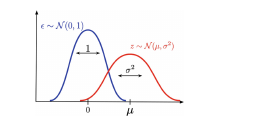

Fig.3 An example of reparameterizing a Gaussian distribution: We scale .ϵ distributed according to the standard Gaussian by .σ, and shift it by .μ.

### Reparameterization Trick

The idea is to express a random variable as a composition of primitive transformations (e.g., arithmetic operations, logarithm, etc.) of an independent random variable with a simple distribution. For example, if we consider a Gaussian random variable $ z $ with a mean $ \mu $ and variance $ \sigma^2 $, and an independent random variable $ \epsilon \sim N(\epsilon | 0, 1) $, then the following holds:

$$
z = \mu + \sigma \cdot \epsilon
$$

Now, if we sample $ \epsilon $ from the standard Gaussian, and apply the above transformation, then we get a sample from $ N(z | \mu, \sigma) $. This idea can be generalized to other distributions as well.

The reparameterization trick can be used in the encoder $ q_\phi(z|x) $. By using this trick, we can drastically reduce the variance of the gradient because the randomness comes from the independent source $ p(\epsilon) $, and we calculate the gradient with respect to a deterministic function (i.e., a neural network), not random variables.

### Application in VAEs

In the VAE framework, we will apply the reparameterization trick to the latent variable $ z $. The encoder $ q_\phi(z|x) $ outputs two values: the mean $ \mu_\phi(x) $ and log-variance $ \log \sigma^2_\phi(x) $ for each input $ x $. Instead of sampling directly from $ q_\phi(z|x) $, we sample an independent Gaussian $ \epsilon \sim N(\epsilon | 0, 1) $ and apply the following transformation:

$$
z_\phi = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon
$$

Here, $ \mu_\phi(x) $ and $ \sigma_\phi(x) $ are outputs of the encoder neural network. This ensures that we can backpropagate through the reparameterization, reducing the variance of the gradient estimates.

### Training the VAE

The training objective for the VAE is to minimize the **negative ELBO**:

$$
\mathcal{L}(\phi, \theta; x) = - \mathbb{E}_{q_\phi(z|x)} \left[\ln p_\theta(x|z)\right] + \text{KL}\left(q_\phi(z|x) || p(z)\right)
$$

In practice, we approximate the expectation $ \mathbb{E}_{q_\phi(z|x)} $ by taking a single sample from the variational posterior:

$$
z_\phi = \mu_\phi(x) + \sigma_\phi(x) \cdot \epsilon
$$

where $ \epsilon \sim N(0, I) $. This allows the model to be trained using stochastic gradient descent, where we only need a single sample of $ z $ during each training iteration.

### Summary

- The reparameterization trick is used to express a random variable $ z $ as a deterministic transformation of an independent random variable $ \epsilon $, making the gradient computation more stable.
- For VAEs, we apply the reparameterization trick to sample $ z $ from the variational posterior $ q_\phi(z|x) $.
- The training objective is the negative ELBO, and the reparameterization trick allows us to sample $ z $ efficiently and compute gradients for optimization. 

##  VAE Code Implementation

### Encoder Class

The encoder class takes in an input $ x $, passes it through the encoder network, and generates the mean $ \mu_\phi(x) $ and log-variance $ \log \sigma_\phi^2(x) $ of the variational posterior $ q_\phi(z|x) $. We then use the **reparameterization trick** to sample from this posterior.

class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()
        # The init of the encoder network.
        self.encoder = encoder_net

    # Reparameterization trick for Gaussians.
    @staticmethod
    def reparameterization(mu, log_var):
        # The formula is the following:
        # z = mu + std * epsilon
        # epsilon ~ Normal(0, 1)
        
        # Get the standard deviation from the log-variance.
        std = torch.exp(0.5 * log_var)
        
        # Sample epsilon from Normal(0, 1).
        eps = torch.randn_like(std)
        
        # Final output
        return mu + std * eps

    # Output of the encoder network (mean and log-variance).
    def encode(self, x):
        # Calculate the output of the encoder network of size 2M.
        h_e = self.encoder(x)
        
        # Split the output into the mean and log-variance.
        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1)
        
        return mu_e, log_var_e

    # Sampling procedure using reparameterization.
    def sample(self, x=None, mu_e=None, log_var_e=None):
        if mu_e is None and log_var_e is None:
            # Calculate mean and log-variance from the encoder.
            mu_e, log_var_e = self.encode(x)
        
        # Apply the reparameterization trick.
        return self.reparameterization(mu_e, log_var_e)

    # Log-probability of the sample used for ELBO calculation.
    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if x is not None:
            # Calculate corresponding sample if only x is provided.
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        
        # Return the log-normal distribution.
        return log_normal_diag(z, mu_e, log_var_e)

    # Forward pass: either log-probability or sampling.
    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x)
        else:
            return self.sample(x)
## 5.3.5 VAE Code Implementation

### Encoder Class

The encoder class takes in an input $ x $, passes it through the encoder network, and generates the mean $ \mu_\phi(x) $ and log-variance $ \log \sigma_\phi^2(x) $ of the variational posterior $ q_\phi(z|x) $. We then use the **reparameterization trick** to sample from this posterior.

```python
class Encoder(nn.Module):
    def __init__(self, encoder_net):
        super(Encoder, self).__init__()
        # The init of the encoder network.
        self.encoder = encoder_net

    # Reparameterization trick for Gaussians.
    @staticmethod
    def reparameterization(mu, log_var):
        # The formula is the following:
        # z = mu + std * epsilon
        # epsilon ~ Normal(0, 1)
        
        # Get the standard deviation from the log-variance.
        std = torch.exp(0.5 * log_var)
        
        # Sample epsilon from Normal(0, 1).
        eps = torch.randn_like(std)
        
        # Final output
        return mu + std * eps

    # Output of the encoder network (mean and log-variance).
    def encode(self, x):
        # Calculate the output of the encoder network of size 2M.
        h_e = self.encoder(x)
        
        # Split the output into the mean and log-variance.
        mu_e, log_var_e = torch.chunk(h_e, 2, dim=1)
        
        return mu_e, log_var_e

    # Sampling procedure using reparameterization.
    def sample(self, x=None, mu_e=None, log_var_e=None):
        if mu_e is None and log_var_e is None:
            # Calculate mean and log-variance from the encoder.
            mu_e, log_var_e = self.encode(x)
        
        # Apply the reparameterization trick.
        return self.reparameterization(mu_e, log_var_e)

    # Log-probability of the sample used for ELBO calculation.
    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if x is not None:
            # Calculate corresponding sample if only x is provided.
            mu_e, log_var_e = self.encode(x)
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        
        # Return the log-normal distribution.
        return log_normal_diag(z, mu_e, log_var_e)

    # Forward pass: either log-probability or sampling.
    def forward(self, x, type='log_prob'):
        assert type in ['encode', 'log_prob'], 'Type could be either encode or log_prob'
        if type == 'log_prob':
            return self.log_prob(x)
        else:
            return self.sample(x)

class Decoder(nn.Module):
    def __init__(self, decoder_net, distribution='categorical', num_vals=None):
        super(Decoder, self).__init__()
        # The decoder network.
        self.decoder = decoder_net
        
        # The distribution used for the decoder.
        self.distribution = distribution
        
        # The number of possible values (used for categorical distribution).
        self.num_vals = num_vals

    # This function calculates parameters of the likelihood function p(x|z).
    def decode(self, z):
        # Apply the decoder network.
        h_d = self.decoder(z)
        
        if self.distribution == 'categorical':
            # Reshape to (Batch size, Dimensionality, Number of Values).
            b = h_d.shape[0]
            d = h_d.shape[1] // self.num_vals
            h_d = h_d.view(b, d, self.num_vals)
            
            # Apply softmax to get probabilities.
            mu_d = torch.softmax(h_d, 2)
            return [mu_d]
        
        elif self.distribution == 'bernoulli':
            # Apply sigmoid for Bernoulli distribution.
            mu_d = torch.sigmoid(h_d)
            return [mu_d]
        
        else:
            raise ValueError('Only: "categorical", "bernoulli"')

    # Sampling from the decoder.
    def sample(self, z):
        outs = self.decode(z)
        
        if self.distribution == 'categorical':
            # Use the output of the decoder.
            mu_d = outs[0]
            return mu_d

### Summary:




- **Encoder**: Takes $ x $, computes the mean and log-variance, and applies the reparameterization trick to sample $ z $.
- **Decoder**: Takes $ z $ and produces the parameters of the likelihood function, using a categorical or Bernoulli distribution.
- **VAE Loss**: The ELBO is computed and used to train the model, where we sample from the variational posterior $ q_\phi(z|x) $ using the reparameterization trick and maximize the likelihood of the observed data while regularizing the latent space.


##  VAE Implementation

### Prior Class

In the current implementation, the prior is a simple standard Gaussian distribution. Although we could use a built-in PyTorch distribution, we chose not to for two reasons:
1. It is important to think of the prior as a crucial component in VAEs.
2. We can implement a learnable prior (e.g., a flow-based prior, VampPrior, a mixture of distributions).

```python
class Prior(nn.Module):
    def __init__(self, L):
        super(Prior, self).__init__()
        self.L = L

    def sample(self, batch_size):
        # Sample from a standard Gaussian distribution.
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
        # Log-probability of z from a standard normal distribution.
        return log_standard_normal(z)
class VAE(nn.Module):
    def __init__(self, encoder_net, decoder_net, num_vals=256, L=16, likelihood_type='categorical'):
        super(VAE, self).__init__()
        print('VAE by JT.')

        self.encoder = Encoder(encoder_net=encoder_net)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)
        self.prior = Prior(L=L)

        self.num_vals = num_vals
        self.likelihood_type = likelihood_type

    def forward(self, x, reduction='avg'):
        # Encoder
        mu_e, log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        # ELBO Calculation
        RE = self.decoder.log_prob(x, z)
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)

        if reduction == 'sum':
            return -(RE + KL).sum()
        else:
            return -(RE + KL).mean()

    def sample(self, batch_size=64):
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)
# Example of Encoder Network
encoder = nn.Sequential(
    nn.Linear(D, M), nn.LeakyReLU(),
    nn.Linear(M, M), nn.LeakyReLU(),
    nn.Linear(M, 2 * L)  # Output mean and log-variance
)

# Example of Decoder Network
decoder = nn.Sequential(
    nn.Linear(L, M), nn.LeakyReLU(),
    nn.Linear(M, M), nn.LeakyReLU(),
    nn.Linear(M, num_vals * D)  # Output the probability distribution
)class VAE(nn.Module):
    def __init__(self, encoder_net, decoder_net, num_vals=256, L=16, likelihood_type='categorical'):
        super(VAE, self).__init__()
        print('VAE by JT.')

        # Encoder, Decoder, and Prior initialization
        self.encoder = Encoder(encoder_net=encoder_net)
        self.decoder = Decoder(distribution=likelihood_type, decoder_net=decoder_net, num_vals=num_vals)
        self.prior = Prior(L=L)

        self.num_vals = num_vals
        self.likelihood_type = likelihood_type

    def forward(self, x, reduction='avg'):
        # 1. Encoder: Calculate the mean (mu_e) and log variance (log_var_e) from the encoder
        mu_e, log_var_e = self.encoder.encode(x)
        
        # 2. Sample the latent variable z using the reparameterization trick
        z = self.encoder.sample(mu_e=mu_e, log_var_e=log_var_e)

        # 3. ELBO Calculation
        #   - RE (Reconstruction Error) is the negative log-likelihood of the data under the decoder
        RE = self.decoder.log_prob(x, z)
        
        #   - KL Divergence between the posterior and the prior
        KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)).sum(-1)

        # 4. Total Loss (Negative ELBO)
        if reduction == 'sum':
            total_loss = -(RE + KL).sum()
        else:
            total_loss = -(RE + KL).mean()

        return total_loss

    def sample(self, batch_size=64):
        # Sampling from the prior and passing through the decoder
        z = self.prior.sample(batch_size=batch_size)
        return self.decoder.sample(z)



##  Typical Issues with VAEs

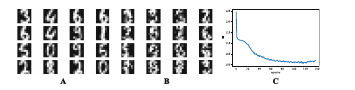

Fig.4 An example of outcomes after the training: (a) Randomly selected real images. (b) Unconditional generations from the VAE. (c) The validation curve during training.


VAEs constitute a very powerful class of models, mainly due to their flexibility. Unlike flow-based models, they do not require the invertibility of neural networks; thus, we can use any arbitrary architecture for encoders and decoders. In contrast to ARMs, they learn a low-dimensional data representation, and we can control the bottleneck (i.e., the dimensionality of the latent space). However, they also suffer from several issues. Except for the ones mentioned before (i.e., a necessity of an efficient integral estimation, a gap between the ELBO and the log-likelihood function for too simplistic variational posteriors), the potential problems are the following:

- **Posterior Collapse**: 
  Let us take a look at the ELBO and the regularization term. For a non-trainable prior like the standard Gaussian, the regularization term will be minimized if: 
  $$ \forall x, q_\phi(z|x) = p(z) $$ 
  This may happen if the decoder is so powerful that it treats $z$ as noise, e.g., when a decoder is expressed by an AR model [10]. This issue is known as **posterior collapse** [11].

- **Hole Problem**:
  Another issue is associated with a mismatch between the aggregated posterior, 
  $$ 1/N \sum_{n=1}^{N} q_\phi(z|x_n), $$ 
  and the prior $p(z)$. Imagine that we have the standard Gaussian prior and the aggregated posterior (i.e., an average of variational posteriors over all training data). As a result, there are regions where the prior assigns a high probability, but the aggregated posterior assigns a low probability, or vice versa. Then, sampling from these "holes" provides unrealistic latent values, and the decoder produces images of very low quality. This problem is referred to as the **hole problem** [12].

- **Out-of-Distribution Problem**:
  The last problem we want to discuss is more general and affects all deep generative models. As it was noticed in [13], deep generative models (including VAEs) fail to properly detect out-of-distribution examples. Out-of-distribution datapoints are examples that follow a totally different distribution than the one a model was trained on. For instance, let us assume that our model is trained on MNIST, and then FashionMNIST examples are out-of-distribution. Intuition tells us that a properly trained deep generative model should assign a high probability to in-distribution examples and a low probability to out-of-distribution points. Unfortunately, as shown in [13], this is not the case. The **out-of-distribution problem** remains one of the main unsolved problems in deep generative modeling [14].

##  There Is More!

There are a plethora of papers that extend VAEs and apply them to many problems. Below, we will list out selected papers and only touch upon the vast literature on the topic!

### Estimation of the Log-Likelihood Using Importance Weighting
As we indicated multiple times, the ELBO is the lower bound to the log-likelihood, and it rather should not be used as a good estimate of the log-likelihood. In [7, 15], an importance weighting procedure is advocated to better approximate the log-likelihood, namely:
$$ \ln p(x) \approx \frac{1}{K} \sum_{k=1}^{K} \ln \frac{p(x, z_k)}{q_\phi(z_k|x)} $$ 
where $z_k \sim q_\phi(z_k|x)$. Notice that the logarithm is outside the expected value. As shown in [15], using importance weighting with sufficiently large $K$ gives a good estimate of the log-likelihood. In practice, $K$ is taken to be 512 or more if the computational budget allows.

### Enhancing VAEs

- **Better Encoders**: After introducing the idea of VAEs, many papers focused on proposing a flexible family of variational posteriors. The most prominent direction is based on utilizing conditional flow-based models [16–21].

- **Better Decoders**: VAEs allow using any neural network to parameterize the decoder. Therefore, we can use fully connected networks, fully convolutional networks, ResNets, or ARMs. For instance, in [22], a PixelCNN-based decoder was used in a VAE.

- **Better Priors**: If there is a big mismatch between the aggregated posterior and the prior, it can be a serious issue. To alleviate this, many papers use multimodal priors, such as the **VampPrior** [23], a flow-based prior [24, 25], an ARM-based prior [26], or using resampling ideas [27].

### Extending VAEs

- **Semi-Supervised VAEs**: In [28], a semi-supervised VAE was proposed, which was further extended to the concept of **fair representations** [29, 30].

- **VAEs for Non-Image Data**: Although VAEs have mostly been used for image data, they can also be applied to other domains, such as sequential data (e.g., text) [11] or molecular graph generation [32].

- **Hierarchical VAEs**: Recently, many VAEs with a deep, hierarchical structure of latent variables have been proposed, achieving remarkable results. Notable models include **BIVA** [45], **NVAE** [46], and very deep VAEs [47].

- **Adversarial Auto-Encoders**: An interesting perspective on VAEs is presented in [48], where the prior is trained with an adversarial loss, allowing the model to benefit from adversarial learning.

- **Adversarial Attacks**: VAEs are known to be susceptible to adversarial attacks. A possible remedy for this is to apply **MCMC** techniques at the inference time [50].
## Improving Variational Auto-encoders

###  Priors

####  Insights from Rewriting the ELBO

One of the crucial components of VAEs is the marginal distribution over $ z $'s. Now, we will take a closer look at this distribution, also called the prior. Before we start thinking about improving it, we inspect the ELBO one more time. We can write the ELBO as follows:

$$
\mathbb{E}_{x \sim p_{\text{data}}(x)}[\ln p(x)] \geq \mathbb{E}_{x \sim p_{\text{data}}(x)} \mathbb{E}_{q_\phi(z|x)} \left[ \ln p_\theta(x|z) + \ln p_\lambda(z) - \ln q_\phi(z|x) \right]
$$

where we explicitly highlight the summation over training data, namely, the expected value with respect to $ x $'s from the empirical distribution $ p_{\text{data}}(x) = \frac{1}{N} \sum_{n=1}^{N} \delta(x - x_n) $, and $ \delta(\cdot) $ is the Dirac delta. The ELBO consists of two parts:

- The **reconstruction error** $ \Delta_{\text{RE}} $:
$$
\text{RE} = \mathbb{E}_{x \sim p_{\text{data}}(x)} \mathbb{E}_{q_\phi(z|x)}[\ln p_\theta(x|z)]
$$

- The **regularization term** between the encoder and the prior $ \Delta_{\Omega} $:
$$
\Omega = \mathbb{E}_{x \sim p_{\text{data}}(x)} \mathbb{E}_{q_\phi(z|x)}[\ln p_\lambda(z) - \ln q_\phi(z|x)]
$$

Further, let us play a little bit with the regularization term $ \Omega $:

$$
\Omega = \mathbb{E}_{x \sim p_{\text{data}}(x)} \mathbb{E}_{q_\phi(z|x)}[\ln p_\lambda(z) - \ln q_\phi(z|x)]
$$

$$
\int \int \ln p_\lambda(z) - \ln q_\phi(z|x) \, dz \, dx
$$

$$
= \sum_{n=1}^{N} \int \delta(x - x_n) q_\phi(z|x) \ln p_\lambda(z) - \ln q_\phi(z|x) \, dz \, dx
$$

$$
= \frac{1}{N} \sum_{n=1}^{N} \int q_\phi(z|x_n) \left[\ln p_\lambda(z) - \ln q_\phi(z|x_n)\right] \, dz
$$

$$
= \frac{1}{N} \sum_{n=1}^{N} \left[ \int q_\phi(z|x_n) \ln p_\lambda(z) \, dz - \int q_\phi(z|x_n) \ln q_\phi(z|x_n) \, dz \right]
$$

$$
= -\frac{1}{N} \sum_{n=1}^{N} \left[ \text{CE}(q_\phi(z) || p_\lambda(z)) + H(q_\phi(z|x)) \right]
$$

where we use the property of the Dirac delta: 
$$
\delta(a - a') f(a) da = f(a')
$$
and we use the notion of the **aggregated posterior** $ q(z) $ defined as:
$$
q(z) = \frac{1}{N} \sum_{n=1}^{N} q_\phi(z|x_n)
$$

An example of the aggregated posterior is schematically depicted in Fig.5. Eventually, we obtain two terms:

1. The first term, $ \text{CE}(q_\phi(z) || p_\lambda(z)) $, is the **cross-entropy** between the aggregated posterior and the prior.
2. The second term, $ H(q_\phi(z|x)) $, is the **conditional entropy** of $ q_\phi(z|x) $ with the empirical distribution $ p_{\text{data}}(x) $.

I highly recommend doing this derivation step by step, as it helps a lot in understanding what is going on here. Interestingly, there is another possibility to rewrite $ \Omega $ using three terms, with the **total correlation** [51]. We will not use it here, so it is left as a "homework." Anyway, one may ask, why is it useful to rewrite the ELBO? The answer is rather straightforward: We can analyze it from a different perspective! In this section, we will focus on the prior, an important component in the generative part that is very often neglected. Many Bayesianists argue that a prior should not be learned, but VAEs are not Bayesian models, so who says we cannot learn the prior? As we will see shortly, a non-learnable prior could be quite problematic, especially for the generation process.
##  Improving Variational Auto-encoders

###  Priors

####  Insights from Rewriting the ELBO

One of the crucial components of VAEs is the marginal distribution over $ z $'s. Now, we will take a closer look at this distribution, also called the prior. Before we start thinking about improving it, we inspect the ELBO one more time. We can write the ELBO as follows:

$$
\mathbb{E}_{x \sim p_{\text{data}}(x)}[\ln p(x)] \geq \mathbb{E}_{x \sim p_{\text{data}}(x)} \mathbb{E}_{q_\phi(z|x)} \left[ \ln p_\theta(x|z) + \ln p_\lambda(z) - \ln q_\phi(z|x) \right]
$$

where we explicitly highlight the summation over training data, namely, the expected value with respect to $ x $'s from the empirical distribution $ p_{\text{data}}(x) = \frac{1}{N} \sum_{n=1}^{N} \delta(x - x_n) $, and $ \delta(\cdot) $ is the Dirac delta. The ELBO consists of two parts:

- The **reconstruction error** $ \Delta_{\text{RE}} $:
$$
\text{RE} = \mathbb{E}_{x \sim p_{\text{data}}(x)} \mathbb{E}_{q_\phi(z|x)}[\ln p_\theta(x|z)]
$$

- The **regularization term** between the encoder and the prior $ \Delta_{\Omega} $:
$$
\Omega = \mathbb{E}_{x \sim p_{\text{data}}(x)} \mathbb{E}_{q_\phi(z|x)}[\ln p_\lambda(z) - \ln q_\phi(z|x)]
$$

Further, let us play a little bit with the regularization term $ \Omega $:

$$
\Omega = \mathbb{E}_{x \sim p_{\text{data}}(x)} \mathbb{E}_{q_\phi(z|x)}[\ln p_\lambda(z) - \ln q_\phi(z|x)]
$$

$$
\int \int \ln p_\lambda(z) - \ln q_\phi(z|x) \, dz \, dx
$$

$$
= \sum_{n=1}^{N} \int \delta(x - x_n) q_\phi(z|x) \ln p_\lambda(z) - \ln q_\phi(z|x) \, dz \, dx
$$

$$
= \frac{1}{N} \sum_{n=1}^{N} \int q_\phi(z|x_n) \left[\ln p_\lambda(z) - \ln q_\phi(z|x_n)\right] \, dz
$$

$$
= \frac{1}{N} \sum_{n=1}^{N} \left[ \int q_\phi(z|x_n) \ln p_\lambda(z) \, dz - \int q_\phi(z|x_n) \ln q_\phi(z|x_n) \, dz \right]
$$

$$
= -\frac{1}{N} \sum_{n=1}^{N} \left[ \text{CE}(q_\phi(z) || p_\lambda(z)) + H(q_\phi(z|x)) \right]
$$

where we use the property of the Dirac delta: 
$$
\delta(a - a') f(a) da = f(a')
$$
and we use the notion of the **aggregated posterior** $ q(z) $ defined as:
$$
q(z) = \frac{1}{N} \sum_{n=1}^{N} q_\phi(z|x_n)
$$

An example of the aggregated posterior is schematically depicted in Fig. 5.5. Eventually, we obtain two terms:

1. The first term, $ \text{CE}(q_\phi(z) || p_\lambda(z)) $, is the **cross-entropy** between the aggregated posterior and the prior.
2. The second term, $ H(q_\phi(z|x)) $, is the **conditional entropy** of $ q_\phi(z|x) $ with the empirical distribution $ p_{\text{data}}(x) $.

I highly recommend doing this derivation step by step, as it helps a lot in understanding what is going on here. Interestingly, there is another possibility to rewrite $ \Omega $ using three terms, with the **total correlation** [51]. We will not use it here, so it is left as a "homework." Anyway, one may ask, why is it useful to rewrite the ELBO? The answer is rather straightforward: We can analyze it from a different perspective! In this section, we will focus on the prior, an important component in the generative part that is very often neglected. Many Bayesianists argue that a prior should not be learned, but VAEs are not Bayesian models, so who says we cannot learn the prior? As we will see shortly, a non-learnable prior could be quite problematic, especially for the generation process.



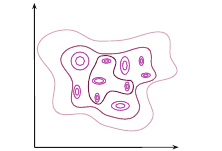
Fig.5 An example of the aggregated posterior. Individual points are encoded as Gaussians in the 2D latent space (magenta) and the mixture of variational posteriors (the aggregated posterior) is presented by contours.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, MultivariateNormal
import matplotlib.pyplot as plt

# Define the encoder and decoder architectures (simplified for demonstration)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        output = torch.sigmoid(self.fc2(h))  # assuming binary data for simplicity
        return output

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z), mean, logvar

# Define the loss function (ELBO)
def loss_function(recon_x, x, mean, logvar):
    # Reconstruction term (RE)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # Regularization term (Ω)
    # Using a standard normal prior
    p_lambda_z = Normal(torch.zeros_like(mean), torch.ones_like(mean))
    q_phi_z = Normal(mean, torch.exp(0.5 * logvar))
    
    # Cross-entropy (CE) between the aggregated posterior and prior
    # We use the KL divergence as a regularizer in VAEs
    # The formula for the KL divergence is:
    # D_KL(q(z|x) || p(z)) = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # Where sigma is the std deviation and mu is the mean of the posterior q(z|x)
    # In this case, we assume p(z) is a standard normal (mean 0, variance 1)
    
    # KL divergence term
    KL_divergence = torch.sum(0.5 * (torch.exp(logvar) + mean**2 - 1 - logvar))
    
    # Total loss = Reconstruction + KL divergence
    return BCE + KL_divergence

# Hyperparameters
input_dim = 784  # Example for MNIST (28x28)
hidden_dim = 400
latent_dim = 20
batch_size = 64
epochs = 10

# Set up the model, optimizer
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Dummy data loader (Replace with actual dataset loading code)
# For example, use MNIST data here
# Assuming data is already flattened to (batch_size, 784) for MNIST
# data_loader = ...

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):  # Replace with actual data loader
        data = data.view(-1, input_dim)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mean, logvar = model(data)
        
        # Compute loss
        loss = loss_function(recon_batch, data, mean, logvar)
        
        # Backward pass and optimization
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f"Epoch {epoch}, Average Loss: {train_loss / len(data_loader.dataset)}")

# To visualize the aggregated posterior, we can plot the distribution
# Example for 2D latent space visualization
z_samples = mean.detach().cpu().numpy()
plt.scatter(z_samples[:, 0], z_samples[:, 1], alpha=0.5)
plt.title('Aggregated Posterior in 2D Latent Space')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the architecture of the Encoder and Decoder networks
def encoder(x, weights1, bias1, weights2, bias2, weights3, bias3):
    """ Encoder Network: z_mean, z_logvar """
    h = np.tanh(np.dot(x, weights1) + bias1)  # First layer with tanh activation
    z_mean = np.dot(h, weights2) + bias2     # Mean of the latent space
    z_logvar = np.dot(h, weights3) + bias3   # Log variance of the latent space
    return z_mean, z_logvar

def decoder(z, weights1, bias1, weights2, bias2):
    """ Decoder Network: Reconstruct the input data """
    h = np.tanh(np.dot(z, weights1) + bias1)  # First layer with tanh activation
    x_reconstructed = np.dot(h, weights2) + bias2  # Output layer
    return x_reconstructed

def reparameterize(z_mean, z_logvar):
    """ Reparameterization Trick to sample from q(z|x) """
    epsilon = np.random.randn(*z_mean.shape)  # Random noise from standard normal
    z = z_mean + np.exp(0.5 * z_logvar) * epsilon  # Sample z
    return z

# Loss function (ELBO)
def loss_function(x, x_reconstructed, z_mean, z_logvar):
    """ Compute the ELBO loss: reconstruction error + KL divergence """
    # Reconstruction error (binary cross entropy)
    recon_loss = np.sum((x - x_reconstructed) ** 2)

    # KL divergence
    kl_div = -0.5 * np.sum(1 + z_logvar - z_mean**2 - np.exp(z_logvar))

    # Total loss
    return recon_loss + kl_div

# Initialize network weights and biases
input_dim = 784  # Example: MNIST data (28x28 images flattened)
hidden_dim = 400
latent_dim = 20
output_dim = input_dim

# Encoder weights and biases
weights1_enc = np.random.randn(input_dim, hidden_dim) * 0.01
bias1_enc = np.zeros(hidden_dim)
weights2_enc = np.random.randn(hidden_dim, latent_dim) * 0.01
bias2_enc = np.zeros(latent_dim)
weights3_enc = np.random.randn(hidden_dim, latent_dim) * 0.01
bias3_enc = np.zeros(latent_dim)

# Decoder weights and biases
weights1_dec = np.random.randn(latent_dim, hidden_dim) * 0.01
bias1_dec = np.zeros(hidden_dim)
weights2_dec = np.random.randn(hidden_dim, output_dim) * 0.01
bias2_dec = np.zeros(output_dim)

# Training parameters
learning_rate = 1e-3
epochs = 10
batch_size = 64

# Dummy data (replace with real dataset, e.g., MNIST flattened images)
# x_data is a batch of flattened images, size [batch_size, input_dim]
x_data = np.random.randn(batch_size, input_dim)  # Random data for now

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for i in range(batch_size):  # Simulate a batch for training
        x = x_data[i]  # Sample a single data point
        
        # Forward pass: Encoder
        z_mean, z_logvar = encoder(x, weights1_enc, bias1_enc, weights2_enc, bias2_enc, weights3_enc, bias3_enc)
        
        # Reparameterization trick
        z = reparameterize(z_mean, z_logvar)
        
        # Forward pass: Decoder
        x_reconstructed = decoder(z, weights1_dec, bias1_dec, weights2_dec, bias2_dec)
        
        # Compute loss
        loss = loss_function(x, x_reconstructed, z_mean, z_logvar)
        total_loss += loss
        
        # Backpropagation (gradient descent, simplified version)
        # Compute gradients (manually for simplicity)
        # Note: Here we would typically use backpropagation, but we'll skip it
        # to keep things simple without frameworks like PyTorch

        # Update parameters (gradient descent)
        weights1_enc -= learning_rate * np.dot(x[:, None], (z_mean - x_reconstructed))  # Simplified update
        bias1_enc -= learning_rate * np.sum(z_mean - x_reconstructed)
        
        # Add similar updates for the other weights and biases...

    print(f'Epoch {epoch+1}, Total Loss: {total_loss / batch_size}')
    
# Visualize aggregated posterior (assuming 2D latent space)
# For demonstration, let's assume z_mean is 2D
z_samples = np.random.randn(batch_size, 2)  # Placeholder, replace with real latents
plt.scatter(z_samples[:, 0], z_samples[:, 1])
plt.title('Aggregated Posterior in Latent Space')
plt.show()


In [ ]:
import random
import math
import matplotlib.pyplot as plt

# Basic activation function: Tanh
def tanh(x):
    return math.tanh(x)

# Dot product function
def dot_product(vec1, vec2):
    return sum(a * b for a, b in zip(vec1, vec2))

# Matrix multiplication (for layer transformation)
def matmul(A, B):
    # A is an m x n matrix, B is an n x p matrix
    # Result will be an m x p matrix
    result = []
    for row in A:
        result_row = []
        for col in zip(*B):
            result_row.append(dot_product(row, col))
        result.append(result_row)
    return result

# Encoder Network: computes z_mean, z_logvar
def encoder(x, weights1, bias1, weights2, bias2, weights3, bias3):
    h = [tanh(dot_product(x, w) + b) for w, b in zip(weights1, bias1)]
    z_mean = [dot_product(h, w) + b for w, b in zip(weights2, bias2)]
    z_logvar = [dot_product(h, w) + b for w, b in zip(weights3, bias3)]
    return z_mean, z_logvar

# Decoder Network: reconstructs the input
def decoder(z, weights1, bias1, weights2, bias2):
    h = [tanh(dot_product(z, w) + b) for w, b in zip(weights1, bias1)]
    x_reconstructed = [dot_product(h, w) + b for w, b in zip(weights2, bias2)]
    return x_reconstructed

# Reparameterization trick: sample from q(z|x)
def reparameterize(z_mean, z_logvar):
    epsilon = [random.gauss(0, 1) for _ in range(len(z_mean))]
    return [z_m + math.exp(0.5 * z_lv) * e for z_m, z_lv, e in zip(z_mean, z_logvar, epsilon)]

# Compute the loss function (ELBO)
def loss_function(x, x_reconstructed, z_mean, z_logvar):
    # Reconstruction error (mean squared error)
    recon_loss = sum((xi - x_reconstructed[i]) ** 2 for i, xi in enumerate(x))
    
    # KL divergence
    kl_div = -0.5 * sum(1 + z_lv - z_m**2 - math.exp(z_lv) for z_m, z_lv in zip(z_mean, z_logvar))
    
    # Total loss (ELBO)
    return recon_loss + kl_div

# Initialize network weights and biases
input_dim = 784  # Example: MNIST data (28x28 images flattened)
hidden_dim = 400
latent_dim = 20
output_dim = input_dim

# Encoder weights and biases (random initialization)
weights1_enc = [[random.gauss(0, 0.01) for _ in range(input_dim)] for _ in range(hidden_dim)]
bias1_enc = [random.gauss(0, 0.01) for _ in range(hidden_dim)]
weights2_enc = [[random.gauss(0, 0.01) for _ in range(hidden_dim)] for _ in range(latent_dim)]
bias2_enc = [random.gauss(0, 0.01) for _ in range(latent_dim)]
weights3_enc = [[random.gauss(0, 0.01) for _ in range(hidden_dim)] for _ in range(latent_dim)]
bias3_enc = [random.gauss(0, 0.01) for _ in range(latent_dim)]

# Decoder weights and biases (random initialization)
weights1_dec = [[random.gauss(0, 0.01) for _ in range(latent_dim)] for _ in range(hidden_dim)]
bias1_dec = [random.gauss(0, 0.01) for _ in range(hidden_dim)]
weights2_dec = [[random.gauss(0, 0.01) for _ in range(hidden_dim)] for _ in range(output_dim)]
bias2_dec = [random.gauss(0, 0.01) for _ in range(output_dim)]

# Training parameters
learning_rate = 0.001
epochs = 10
batch_size = 64

# Dummy data (replace with real dataset)
x_data = [[random.gauss(0, 1) for _ in range(input_dim)] for _ in range(batch_size)]

# Training loop
for epoch in range(epochs):
    total_loss = 0
    for i in range(batch_size):
        x = x_data[i]
        
        # Forward pass: Encoder
        z_mean, z_logvar = encoder(x, weights1_enc, bias1_enc, weights2_enc, bias2_enc, weights3_enc, bias3_enc)
        
        # Reparameterization trick
        z = reparameterize(z_mean, z_logvar)
        
        # Forward pass: Decoder
        x_reconstructed = decoder(z, weights1_dec, bias1_dec, weights2_dec, bias2_dec)
        
        # Compute loss
        loss = loss_function(x, x_reconstructed, z_mean, z_logvar)
        total_loss += loss
        
        # Backpropagation (manual gradient updates are omitted for simplicity)
        # In a real implementation, we'd compute gradients and update weights here
        
    print(f'Epoch {epoch+1}, Total Loss: {total_loss / batch_size}')
    
# Example visualization: Random latent samples
latent_samples = [[random.gauss(0, 1) for _ in range(2)] for _ in range(batch_size)]  # Example 2D latent space
plt.scatter([z[0] for z in latent_samples], [z[1] for z in latent_samples])
plt.title('Aggregated Posterior in Latent Space')
plt.show()


###  What Does the ELBO Tell Us About the Prior?

We know that the regularization term $ \Omega $ consists of two parts: cross-entropy and entropy. Let's first focus on the entropy term, since it is easier to analyze.

When optimizing, we want to maximize the ELBO, so we aim to maximize the entropy:

$$ H(q_{\phi}(z|x)) = - \mathbb{E}_{q_{\phi}(z|x_n)}[\ln q_{\phi}(z|x_n)] $$

This is equivalent to:

$$ \frac{1}{N} \sum_{n=1}^{N} \int q_{\phi}(z|x_n) \ln q_{\phi}(z|x_n) \, dz $$

We assume that we are using Gaussian encoders, i.e., $ q_{\phi}(z|x) = \mathcal{N}(z; \mu(x), \sigma^2(x)) $. The entropy of a Gaussian distribution with a diagonal covariance matrix is:

$$ H(q_{\phi}(z|x)) = \frac{1}{2} \sum_i \ln(2\pi e \sigma_i^2) $$

Now, the question arises: when is this entropy maximized?

The answer is simple: **$ \sigma_i^2 \to +\infty $**. In other words, the entropy tries to stretch the encoders as much as possible by enlarging their variances. However, this doesn't happen in practice, because the decoder works in conjunction with the encoder in the reconstruction error (RE) term. The decoder forces the encoder to be peaked, aiming for a one-to-one mapping from $ x $ to $ z $, much like in a non-stochastic autoencoder.

#### Cross-Entropy Term:

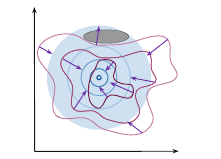

Fig.6 An example of the eﬀect of the cross-entropy optimization with a non-learnable prior. The aggregated posterior (purple contours) tries to match the non-learnable prior (in blue). The purple arrows indicate the change of the aggregated posterior. An example of a hole is presented as a dark gray ellipse.

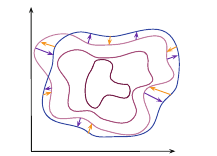

Fig.7 An example of the eﬀect of the cross-entropy optimization with a learnable prior. The aggregated posterior (purple contours) tries to match the learnable prior (blue contours). Notice that the aggregated posterior is modiﬁed to ﬁt the prior (purple arrows), but also the prior is updated to cover the aggregated posterior (orange arrows).

The second part of $ \Omega $ is the cross-entropy:

$$ \text{CE}(q_{\phi}(z) \parallel p_{\lambda}(z)) = - \mathbb{E}_{q_{\phi}(z)}[\ln p_{\lambda}(z)] $$

This cross-entropy term influences the VAE differently. To interpret this, we can ask: *How can we understand the cross-entropy between $ q_{\phi}(z) $ and $ p_{\lambda}(z) $?*

In general, the cross-entropy tells us the average number of bits (or nats, since we use the natural logarithm) needed to identify an event drawn from $ q_{\phi}(z) $, when using a coding scheme based on $ p_{\lambda}(z) $. Since we aim to maximize the ELBO, the negative cross-entropy pushes us to minimize the divergence between $ q_{\phi}(z) $ and $ p_{\lambda}(z) $. In other words, we want $ q_{\phi}(z) $ to match $ p_{\lambda}(z) $.

But why is this important? The cross-entropy forces the aggregated posterior to match the prior. This is the key observation, as the prior $ p_{\lambda}(z) $ acts like an anchor for the posterior distribution $ q_{\phi}(z) $.

#### What Happens with a Non-Learnable Prior?

If the prior is fixed (non-learnable), say a standard Gaussian prior, then optimizing the cross-entropy term forces the aggregated posterior to match this fixed prior. The process can be visualized as follows:

1. The aggregated posterior (purple contours) tries to match the non-learnable prior (in blue). 
2. The aggregated posterior adapts (indicated by the purple arrows) to fit the prior.

However, this optimization can be problematic because the decoder forces the encoder to be peaked, making it nearly impossible to match the fixed-shaped prior perfectly. As a result, "holes" can appear in the latent space—regions where the aggregated posterior assigns low probability, while the prior assigns relatively high probability (as shown by the dark gray ellipse).

This issue becomes especially problematic in generation tasks, as sampling from the prior in these "holes" may result in low-quality samples.

#### What Happens with a Learnable Prior?

If the prior is learnable, the optimization allows both the aggregated posterior and the prior to adapt. Both distributions try to match each other, as shown below:

1. The aggregated posterior (purple contours) adjusts to match the learnable prior (blue contours).
2. The prior is also updated to cover the aggregated posterior (indicated by the orange arrows).

With a learnable prior, the issue of holes is less prominent, especially if the prior is flexible enough. However, other optimization challenges may arise, as both the prior and posterior chase each other during training.

In practice, using a learnable prior seems to be a better approach, though it remains an open question whether training all components at once is the best solution. Additionally, the learnable prior does not impose specific constraints on the latent space representation, such as sparsity. This could result in undesirable problems, such as non-smooth encoders.

#### What Is the Best Prior?

The ultimate question is: What is the best prior?

The answer is hidden in the cross-entropy term. The best prior is actually the **aggregated posterior**:

$$ p_{\lambda}(z) = \frac{1}{N} \sum_{n=1}^{N} q_{\phi}(z|x_n) $$

If we set the prior to be equal to the aggregated posterior, the cross-entropy term becomes the entropy of the posterior, and the regularization term \( \Omega \) becomes minimal. However, this is generally infeasible because:


In [ ]:
import math

# Define a basic Gaussian entropy calculation
def gaussian_entropy(mu, sigma):
    """
    Calculate the entropy of a Gaussian distribution with diagonal covariance matrix.
    
    Args:
    - mu: Mean of the Gaussian (size of latent space)
    - sigma: Standard deviation (size of latent space)

    Returns:
    - entropy: The entropy of the Gaussian distribution
    """
    # Entropy of Gaussian with diagonal covariance: 1/2 * sum(ln(2 * pi * e * sigma^2))
    entropy = 0.5 * sum([math.log(2 * math.pi * math.e * s**2) for s in sigma])
    return entropy

# Reconstruction Error (RE): sum of log-likelihood p(x|z)
def reconstruction_error(x, z, model_decoder):
    """
    Calculate the reconstruction error term of ELBO.
    
    Args:
    - x: The input data
    - z: Latent variables
    - model_decoder: Function to decode z back to x (decoder network)
    
    Returns:
    - RE: Reconstruction error
    """
    reconstructed_x = model_decoder(z)  # decoded output for given z
    # Assuming Gaussian likelihood, we calculate the negative log likelihood
    # Assuming simple MSE for reconstruction
    mse = sum((x_i - rec_x_i)**2 for x_i, rec_x_i in zip(x, reconstructed_x))
    return mse

# Cross-entropy between q(z) and p(z)
def cross_entropy(q_phi_z, p_lambda_z):
    """
    Calculate the cross-entropy between the aggregated posterior q(z) and the prior p(z).
    
    Args:
    - q_phi_z: The aggregated posterior q(z) (mean of all latent variables)
    - p_lambda_z: The prior p(z) (assumed to be Gaussian for simplicity)
    
    Returns:
    - CE: Cross-entropy term
    """
    cross_entropy_value = -sum(q * math.log(p) for q, p in zip(q_phi_z, p_lambda_z))
    return cross_entropy_value

# Implementing a simple model for the decoder (this should be replaced with your own model)
def simple_decoder(z):
    """
    A simple placeholder decoder function that mimics a reconstruction from z.
    """
    return z  # In real-world cases, replace this with an actual decoder model

# Define a sample latent space (for simplicity)
latent_dim = 3
sigma = [1.0] * latent_dim  # Simple standard deviation for each latent dimension
mu = [0.0] * latent_dim     # Simple mean (zero) for each latent dimension

# Example data
x = [1.0, 2.0, 3.0]  # Example input data

# Assume some random latent variables
z = [0.1, 0.2, 0.3]  # Example latent vector

# Calculate the entropy of the posterior q(z|x) (simple Gaussian)
entropy_value = gaussian_entropy(mu, sigma)

# Calculate the reconstruction error (RE) using a simple decoder model
reconstruction_error_value = reconstruction_error(x, z, simple_decoder)

# Assume an aggregated posterior q(z) (mean over all training samples)
aggregated_posterior_q = [0.1, 0.1, 0.1]  # Example

# Assume a prior p(z) (standard Gaussian prior)
prior_p = [0.33, 0.33, 0.33]  # Example (normalized for simplicity)

# Calculate cross-entropy term between q(z) and p(z)
cross_entropy_value = cross_entropy(aggregated_posterior_q, prior_p)

# Combine to form the full ELBO regularization term (Ω)
Omega_value = entropy_value + cross_entropy_value

# Print all calculated terms
print(f"Entropy: {entropy_value}")
print(f"Reconstruction Error: {reconstruction_error_value}")
print(f"Cross-Entropy: {cross_entropy_value}")
print(f"Omega (Regularization term): {Omega_value}")
